In [351]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

MAZE_FILE_NAME = '../Maze_2.png'
ROBOT_FILE_NAME = '../Robot.png'
IMAGE_LADYBUG_FILE_NAME = '../Ladybug_small.png'
MAP_FILE_NAME = '../MapBuilt.txt'

def configureParams(minThreshold=0,
                    maxThreshold=255,
                    filterByArea=True,
                    minArea=0,
                    maxArea=100000,
                    filterByColor=True,
                    blobColour=0,
                    filterByCircularity=True,
                    minCircularity=0,
                    maxCircularity=1,
                    filterByConvexity=True,
                    minConvexity=0,
                    maxConvexity=1,
                    filterByInertia=True,
                    minInertiaRatio=0,
                    maxInertiaRatio=1):
    '''
    All parameters are true by default and detects black blobs by default.
    '''
    # Create params checklist.
    params = cv2.SimpleBlobDetector_Params()

    # Filters by threshold (how gray).
    params.minThreshold = minThreshold
    params.maxThreshold = maxThreshold

    # Filters by area.
    params.filterByArea = filterByArea
    params.minArea = minArea
    params.maxArea = maxArea

    # Filters by colour (0 for black, 1 for white).
    params.filterByColor = filterByColor
    params.blobColor = blobColour

    # Filter by roundness.
    params.filterByCircularity = filterByCircularity
    params.minCircularity = minCircularity
    params.maxCircularity = maxCircularity

    # Filter by convexity.
    params.filterByConvexity = filterByConvexity
    params.minConvexity = minConvexity
    params.maxConvexity = maxConvexity

    # Filter by inertia (elongation).
    params.filterByInertia = filterByInertia
    params.minInertiaRatio = minInertiaRatio
    params.maxInertiaRatio = maxInertiaRatio

    return params

def readImage():
    '''
    Reads the maze image and shows it.
    '''
    im = cv2.imread(MAZE_FILE_NAME, cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

def maskColour(im, lower, upper):
    '''
    Given a lower and upper bound for a HSV colour, returns a binary image that is white-focused.
    '''
    tmp_im = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(tmp_im, lower, upper)
    kernel = np.ones((9, 9), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    i = mask > 0
    tmp_im = np.zeros_like(im, np.uint8)
    tmp_im[i] = im[i]
    tmp_im[tmp_im != 0] = 255
    return tmp_im

def markFeature(im, mask, colour):
    '''
    Mark the image with the features of the mask. Marking uses the simple blob detector and the given colour.
    '''
    params = configureParams(filterByArea=False, filterByColor=False, blobColour=1, minCircularity=0.8, filterByConvexity=False, filterByInertia=False)
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(mask)
    tmp_im = im
    for keypoint in keypoints:
        pt = (np.int(keypoint.pt[0]), np.int(keypoint.pt[1]))
        size = np.int(keypoint.size / 2)
        cv2.circle(tmp_im, pt, size, colour, thickness=4)
    return tmp_im

def markCorners(im):
    '''
    Identify the corners of the maze.
    '''
    cyan = maskColour(im, (89, 50, 0), (91, 255, 255)) # HSV colours
    magenta = maskColour(im, (149, 100, 150), (151, 255, 255)) # HSV colours
    tmp_im = markFeature(im, cyan, (255, 0, 255)) | markFeature(im, magenta, (0, 255, 255)) # RGB colours
    return tmp_im

def fixPerspective():
    pass

def detectWalls():
    pass

def detectPose():
    pass

def generateMap():
    pass


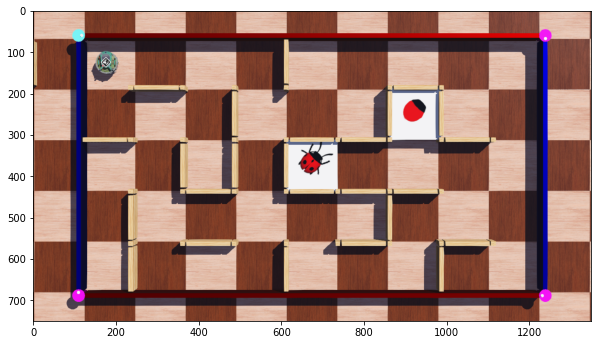

In [316]:
if __name__ == '__main__':
    '''
    Task 1
    '''
    img = readImage()
    plt.figure(figsize=(10,10))
    plt.imshow(img)

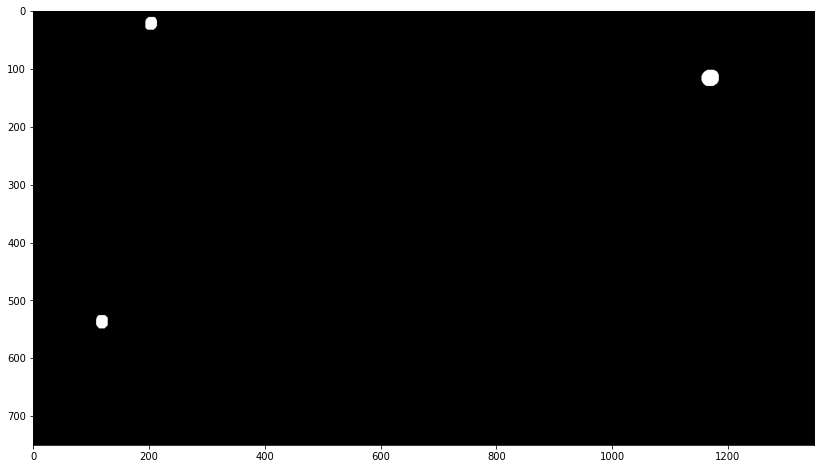

In [352]:
if __name__ == '__main__':
    '''
    Task 2
    '''
    img = readImage()
    img = markCorners(img)
    plt.figure(figsize=(14,14))
    plt.imshow(img)